<span style="color:red" font size="color:black">This notebook allows to easily test some networks and comparing them by displaying spectrogram and audio signal. Further more, you can listen to the inputs and outputs of the networks! 
The error measurement is also plotted at the end of this notebook.</span>


In [1]:
import numpy as np
import scipy.signal
from matplotlib.pyplot import *
import librosa
import os
import matplotlib.pyplot as plt
import librosa.display
from filter_function import *
from spectrogram import *
from wav_preprocessing import *
import matplotlib.image as mpimg
import glob
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D, UpSampling2D, Input,Dropout,Conv2DTranspose,Concatenate, PReLU

from keras import optimizers
from error_measure import *

Using TensorFlow backend.


In [2]:
#stores path's name used in next cells

base_dir = "put the path where all the data is"


test_dir = os.path.join(base_dir, 'test\\')

test_dir_filtré=os.path.join(base_dir, 'test_dir_filtré\\')

In [17]:
#This cells apply the filter to the digits
#fcn is the numerical frequency, defined here by fcn=fc/sr with sr=22050a dn fc your cut off frequency but in Hz

fcn=0.0226
ftype="butter"
ordre=2 #with filtfilt it's a 4 order
b,a = creer_filter(fcn,"highpass",ftype,ordre)

filter_path(test_dir,test_dir_filtré,b,a)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\


In [18]:
# This cell stores the audio spoken digit used for test into the arrays Xtest and Xtest_fil which is Xtest filtered.

Xtest,max_test= dir_to_wav_array(test_dir)
Xtest_fil,max_test_fil=dir_to_wav_array(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


In [19]:
# This cell is similar to the previous one, but the mel spectrogram are stored in this case.
# There is also the phase of the spoken digits in case if.
Xtest_mel,Phase_test=dir_to_log_mel(test_dir)
Xtest_fil_mel,Phase_test_fil=dir_to_log_mel(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


In [20]:
#You can load the following models. The frequency is the cut off of a 4 order butterworth highpass filter. 
#To change the network according to the frequency cut off, you have to rerun the 3 previous cells.
# audio network: audio_network_500Hz_40epochs.h5
#                audio_network_800Hz_40epochs.h5
#                audio_network_1500Hz_40epochs.h5
#                audio_network_1500Hz_80epochs.h5
#                audio_network_3000Hz_40epochs.h5
#                audio_network_3000Hz_80epochs.h5

# mel spectrogram network: mel_spec_network_500Hz_40epochs.h5
#                          mel_spec_network_800Hz_40epochs.h5  
#                          mel_spec_network_1500Hz_40epochs.h5
#                          mel_spec_network_1500Hz_80epochs.h5
#                          mel_spec_network_3000Hz_40epochs.h5
#                          mel_spec_network_3000Hz_80epochs.h5

#I will add the models with a low pass soon !

autoencoder_audio=load_model("audio_network_500Hz_40epochs.h5")
autoencoder_mel=load_model("mel_spec_network_500Hz_40epochs.h5")


In [21]:
# Calculation of the 2 networks ouputs
decoded_mel = autoencoder_mel.predict(Xtest_fil_mel)
decoded_audio = autoencoder_audio.predict(Xtest_fil)

In [22]:
# This cell calculates the mel spectrogram of the audio output of the audio network and store it in an array
Spec_audio_decoded=audioarray_to_melspectro(decoded_audio)

In [23]:
#Lin_dec is the linear scale frequency version and linear amplitude version of the output of the mel network.
#Then merge_specphase_to_audio juste mulptiply the spectrogram contained in Lin_dec with the phase 
#of the output of the audio signal. Then, it stores all of the istft(so the audio signal) in merge_audio

Lin_dec=mel_to_linspec(decoded_mel,sr=8000,n_mels=1024,n_fft=2048)
merge_audio=merge_specphase_to_audio(Lin_dec,decoded_audio)

In [58]:
#You can change here the spoken digit you want to hear and see in differents representations!
#You can choose between 0 and 199 (there are 200 test spoken digits)
#The digits distinguishes themselves by 4 differents spearkers which pronounces several times all numbers between 0 and 9.
#You just have to rerun from here if you want to test differents digits with the same network.
display_index=180


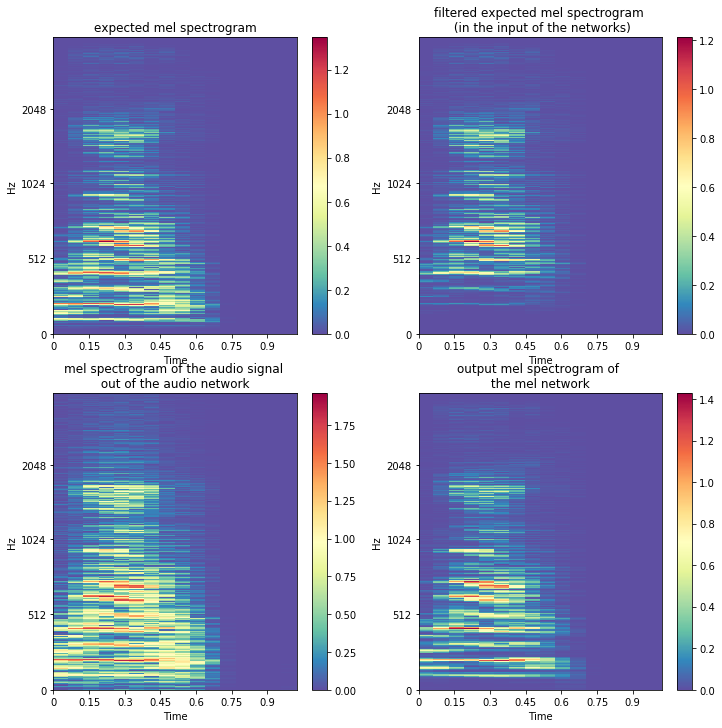

In [59]:
#It displays the spectrograms of the expected signal, filtered expected signal and the outputs of the 2 networks
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
librosa.display.specshow(np.reshape(Xtest_mel[display_index],(1024,16)), sr=8000, x_axis='time', y_axis='mel',fmax=4000,cmap='Spectral_r')
title("expected mel spectrogram")
colorbar()
plt.subplot(2,2,2)
librosa.display.specshow(np.reshape(Xtest_fil_mel[display_index],(1024,16)), sr=8000, x_axis='time', y_axis='mel',fmax=4000,cmap='Spectral_r')
title("filtered expected mel spectrogram \n (in the input of the networks)")
colorbar()
plt.subplot(2,2,3)
librosa.display.specshow(np.reshape(Spec_audio_decoded[display_index],(1024,16)), sr=8000, x_axis='time', y_axis='mel',fmax=4000,cmap='Spectral_r')
title("mel spectrogram of the audio signal \n out of the audio network ")
colorbar()
plt.subplot(2,2,4)
librosa.display.specshow(np.reshape(decoded_mel[display_index],(1024,16)), sr=8000, x_axis='time', y_axis='mel',fmax=4000,cmap='Spectral_r')
title("output mel spectrogram of \n the mel network ")
colorbar()

In [60]:
#Ah finally the listenning !
#You can listen here to the expected signal. 

sr=8000 #sample rate
xtest=np.reshape(Xtest[display_index],(8000))
audio_path_record="put the path where all the data is"
audio_path_record_in=os.path.join(audio_path_record,"expected_signal.wav")
soundfile.write(audio_path_record_in,xtest*max_test[display_index],sr)
ipd.Audio(audio_path_record_in)

In [61]:
#You can listen here to the filtered expected signal. 
xtest_fil=np.reshape(Xtest_fil[display_index],(8000))
audio_path_record_in_fil=os.path.join(audio_path_record,"filtered_expected_signal.wav")
soundfile.write(audio_path_record_in_fil,xtest_fil*max_test_fil[display_index],sr)
ipd.Audio(audio_path_record_in_fil)

In [62]:
#You can listen here to the output of the audio network. 
y=np.reshape(decoded_audio[display_index],(8000))
audio_path_record_out=os.path.join(audio_path_record,"audio_network_output.wav")
soundfile.write(audio_path_record_out,y*max_test[display_index],sr)
ipd.Audio(audio_path_record_out)

In [63]:
#You can listen here to the merged signal.
audio_path_record_audio_merge=os.path.join(audio_path_record,"merged_output.wav")
soundfile.write(audio_path_record_audio_merge,merge_audio[display_index]*2,sr)
ipd.Audio(audio_path_record_audio_merge)

Text(0.5, 1.0, 'audio signal after the merge \n of the mel spectrogram and the phase \n of the left plotted one')

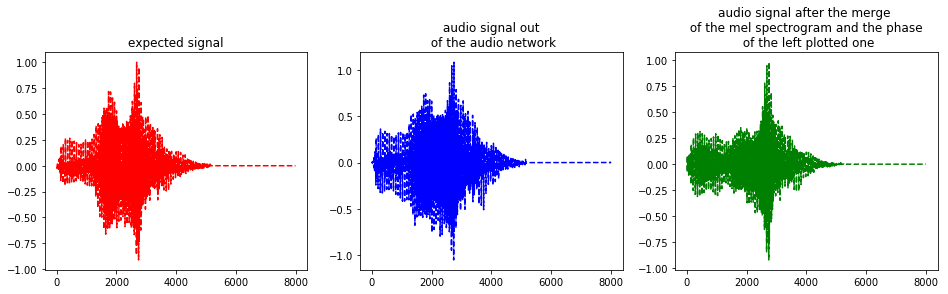

In [54]:
# You can here watch the outputs in the time domain. You can change the window's size and place of the signal you want to see.

lim_sup=7999
lim_inf=0

plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.plot(xtest[lim_inf:lim_sup],"r--")
title("expected signal")
plt.subplot(1,3,2)
plt.plot(y[lim_inf:lim_sup],"b--")
title(" audio signal out \n of the audio network")
plt.subplot(1,3,3)
plt.plot(merge_audio[display_index][lim_inf:lim_sup],"g--")
title("audio signal after the merge \n of the mel spectrogram and the phase \n of the left plotted one")



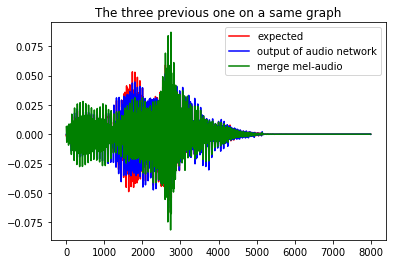

In [52]:

plt.plot(xtest[lim_inf:lim_sup]*1/np.linalg.norm(xtest),"r-",label="expected")
plt.plot(y[lim_inf:lim_sup]*1/np.linalg.norm(y),"b-",label="output of audio network")
plt.plot(merge_audio[display_index][lim_inf:lim_sup]*1/np.linalg.norm(merge_audio[display_index]),"g-",label="merge mel-audio")
title("The three previous one on a same graph")
plt.legend()

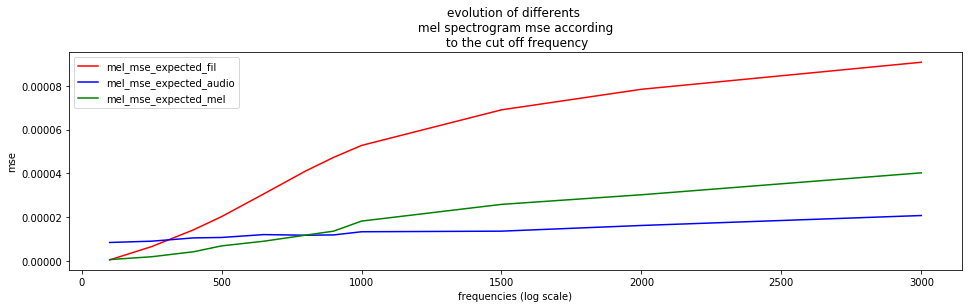

In [41]:
#Mean Squared error plotting for the mel spectrogram. To calculate it, the signal are normalized during the process. 
#The values are an average of the mse for the 200 digits and both networks are trained 40 epochs
fc=[100,250,400,500,650,800,900,1000,1500,2000,3000]
mel_mse_expected_fil=[4.899083107907589e-07,6.581620565635553e-06 ,1.4253546064176374e-05 ,2.02798452596404e-05,3.059972105987759e-05
,4.1077088562028885e-05 ,4.7306026989506134e-05 ,5.2756993255817805e-05 ,6.900860649714932e-05 ,7.839318563822392e-05 ,9.073598754380241e-05]

mel_mse_expected_audio=[8.45009023533109e-06 ,9.045923478437584e-06 ,1.0539854936830291e-05 ,1.073740133854983e-05 ,1.2050821072378661e-05 ,1.1761112717721592e-05 
,1.1896799871816977e-05 ,1.3348344849190107e-05 ,1.361908796958397e-05 ,1.6216031844259575e-05,2.075509121916088e-05 ]

mel_mse_expected_mel=[6.334015694622778e-07,1.93701487728076e-06 ,4.221574206456429e-06 ,6.894075064905749e-06 ,9.015606819444774e-06 ,1.1789361457691057e-05
,1.3618950343630778e-05 ,1.8214523466708357e-05 ,2.584721615496709e-05 ,3.023515332637395e-05 ,4.024768349553545e-05 ]

fig=plt.figure(figsize=(16, 4))

plt.plot(fc,mel_mse_expected_fil,"r",label="mel_mse_expected_fil")
plt.plot(fc,mel_mse_expected_audio,"b",label="mel_mse_expected_audio")
plt.plot(fc,mel_mse_expected_mel,"g",label="mel_mse_expected_mel")
# ax.set_xscale('log')
plt.xlabel("frequencies (log scale)")
plt.ylabel('mse')
title("evolution of differents \n mel spectrogram mse according \n to the cut off frequency" )
plt.legend()
plt.show()

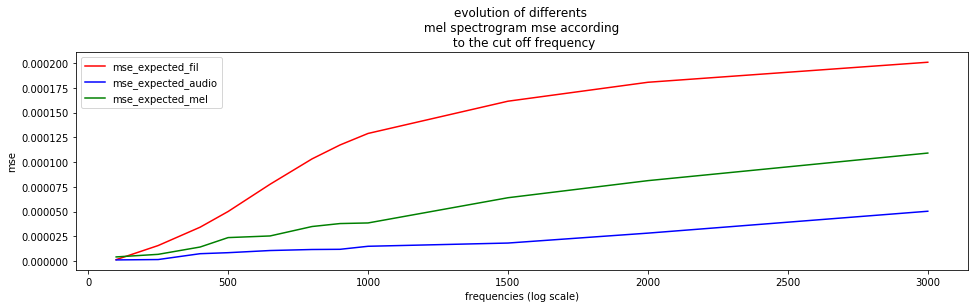

In [40]:
#Mean Squared error plotting for the mel spectrogram. 
mse_expected_fil=[1.446375029707019e-06 ,1.5678172574829692e-05 ,3.422177307968991e-05 ,5.0073371002029336e-05,7.760537658108146e-05 
,0.0001032307532074666 ,0.00011728559086309962 ,0.00012890817369316522 ,0.00016148241079721865 ,0.00018060181913864232 ,0.00020083367439990396 ]

mse_expected_audio=[1.1709043717600109e-06,1.5464223496520057e-06 ,7.452432831659676e-06 ,8.474299870313555e-06,1.0653167908426954e-05 
,1.1689741487763436e-05 ,1.188702350233708e-05 ,1.494346405408763e-05 ,1.8208046916599074e-05 ,2.822905268333845e-05 ,5.0331236627590626e-05]

mse_expected_mel=[4.195195264581628e-06,6.807078485635804e-06 ,1.4196958351330743e-05,2.3719182163922992e-05,2.5377911629047107e-05 ,3.490540757989077e-05 
,3.789871863143999e-05 ,3.850738800504175e-05 ,6.398863878809281e-05 ,8.124327950242894e-05 ,0.00010909449785205259]

fig=plt.figure(figsize=(16, 4))

plt.plot(fc,mse_expected_fil,"r",label="mse_expected_fil")
plt.plot(fc,mse_expected_audio,"b",label="mse_expected_audio")
plt.plot(fc,mse_expected_mel,"g",label="mse_expected_mel")
# ax.set_xscale('log')
plt.xlabel("frequencies (log scale)")
plt.ylabel('mse')
title("evolution of differents \n mel spectrogram mse according \n to the cut off frequency" )
plt.legend()
plt.show()